In [1]:
from mltoolkit import *

In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path

In [4]:
import math, os

In [5]:
PATH = Path("train")
list(PATH.iterdir())

[PosixPath('train/Samsung-Galaxy-Note3'),
 PosixPath('train/Motorola-X'),
 PosixPath('train/Samsung-Galaxy-S4'),
 PosixPath('train/iPhone-6'),
 PosixPath('train/HTC-1-M7'),
 PosixPath('train/LG-Nexus-5x'),
 PosixPath('train/iPhone-4s'),
 PosixPath('train/Motorola-Nexus-6'),
 PosixPath('train/Sony-NEX-7'),
 PosixPath('train/Motorola-Droid-Maxx')]

In [6]:
im = Image.open(PATH/'Samsung-Galaxy-Note3/(GalaxyN3)76.jpg')

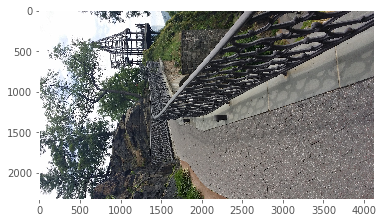

In [7]:
plt.imshow(np.asarray(im))
plt.grid(False)

# Transformations

In [8]:
sz=512

random_crop = transforms.RandomCrop(sz),
random_hflip = transforms.RandomHorizontalFlip(),
random_vflip = transforms.RandomVerticalFlip(),
to_tensor = transforms.ToTensor(),
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
def apply_transforms(x):
    """ Applies a random crop, rotation"""
    x = random_crop[0](x)
    x = random_hflip[0](x)
    x = random_vflip[0](x)
    x = to_tensor[0](x)
    x = normalize(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


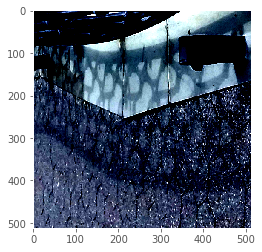

In [9]:
plt.imshow(apply_transforms(im).numpy().transpose((1, 2, 0)));
plt.grid()

*post normalizing the values might be all over the place, hence the warning*

In [10]:
df = folder2df(fpath=PATH)

In [11]:
df.head()

,fname,label
0,train/HTC-1-M7/(HTC-1-M7)1.jpg,HTC-1-M7
1,train/HTC-1-M7/(HTC-1-M7)10.jpg,HTC-1-M7
2,train/HTC-1-M7/(HTC-1-M7)100.jpg,HTC-1-M7
3,train/HTC-1-M7/(HTC-1-M7)101.jpg,HTC-1-M7
4,train/HTC-1-M7/(HTC-1-M7)102.jpg,HTC-1-M7


In [12]:
# lb = LabelBinarizer()
# lb.fit(df.label)
# lb.classes_

In [13]:
train, valid = split_df(df)

# DataSet

In [14]:
class InvasiveDataset(Dataset):
    def __init__(self, df, transform=False):
        self.num_files = df.shape[0]
        self.files_path = df.fname.values
        # incase of multi class
        # self.labels = lb.transform(df.label)
        self.labels = df.label.cat.codes
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        fpath = str(self.files_path[idx])
        x = Image.open(fpath)
        x = apply_transforms(x)
        return x, y

In [15]:
train_ds = InvasiveDataset(train, transform=True)
valid_ds = InvasiveDataset(valid)

In [16]:
len(train_ds)

1978

In [17]:
len(valid_ds)

497

In [18]:
x, y = train_ds[900]
x.shape, y

(torch.Size([3, 512, 512]), 4)

In [19]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [20]:
len(train_dl) # len(train_ds) / batch_size

31

In [21]:
resnet = models.resnet34(pretrained=True)

In [22]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=512, out_features=1000, bias=True)]

In [23]:
# output size for last layer
len(df.label.unique())

9

# Model

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 9)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        # x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        # x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [25]:
model = Net().cuda()

In [26]:
%%prun
x, y = next(iter(train_dl))

Ordered by: internal time

`ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    84   18.750    0.223   18.750    0.223 {built-in method posix.read}
    36   15.801    0.439   15.801    0.439 {built-in method posix.waitpid}
     8    0.139    0.017    0.139    0.017 {built-in method posix.fork}
     1    0.076    0.076   34.830   34.830 <string>:2(<module>)`

Reading is taking time ?

In [27]:
x.shape

torch.Size([64, 3, 512, 512])

In [28]:
y.shape

torch.Size([64])

In [29]:
y

tensor([1, 3, 8, 6, 1, 3, 4, 1, 6, 5, 2, 2, 1, 3, 4, 8, 8, 3, 3, 1, 1, 8, 8, 4,
        3, 7, 7, 7, 4, 6, 3, 5, 8, 2, 7, 3, 6, 6, 6, 0, 8, 8, 2, 1, 8, 1, 8, 6,
        4, 2, 7, 4, 1, 8, 8, 3, 6, 8, 8, 1, 8, 6, 4, 1], dtype=torch.int8)

In [30]:
# model = model.double()

In [31]:
x_features = model.top_model(x.cuda())
x_features.shape

torch.Size([64, 512, 16, 16])

In [32]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [33]:
x_features_ave.shape[0]

64

In [34]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [35]:
y_hat = model(x.cuda())
y_hat.shape

torch.Size([64, 9])

In [36]:
y.shape

torch.Size([64])

Cross Entropy Loss expects is a class index (`0` to `C-1`, where `C` = number of classes)

In [37]:
criteria = nn.CrossEntropyLoss()
criteria(y_hat, y.long().cuda())

tensor(2.2260, device='cuda:0', grad_fn=<NllLossBackward>)

# Learning Rate Finder

In [38]:
len(list(model.parameters()))

116

In [39]:
p = list(model.parameters())[0]

In [40]:
type(p)

torch.nn.parameter.Parameter

In [41]:
p.requires_grad

False

In [42]:
parameters = filter(lambda p: p.requires_grad, model.parameters())

In [43]:
len(list(parameters))

8

In [44]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd, )
    return optim

In [45]:
def save_model(m, path):
    torch.save(m.state_dict(), path)

In [46]:
def load_model(m, path):
    m.load_state_dict(torch.load(path))

In [47]:
criteria = nn.CrossEntropyLoss()

In [48]:
def lr_range_finder(model, train_dl, loss_criteria=None,
                    lr_low=1e-5, lr_high=10, beta=0.98, epochs=1):
    
    os.makedirs('models', exist_ok=True)
    p = "models/tmp.pth"
    save_model(model, str(p))

    lrs = np.logspace(math.log10(lr_low), math.log10(lr_high),
                      num=epochs*len(train_dl), endpoint=True)
    log_lrs = np.log10(lrs)
    avg_loss = 0.
    best_loss = 0.
    btch_idx = 0
    losses = []
    smooth_losses = []
    
    model.train()
    
    for ep in range(epochs):
        for x, y in train_dl:
            optimizer = get_optimizer(model, lr=lrs[btch_idx])
            btch_idx += 1
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            out = model(x)
            loss = loss_criteria(out, y.long())

            # Compute the smoothed loss
            avg_loss = beta * avg_loss + (1 - beta) * loss.item()
            smoothed_loss = avg_loss / (1 - (beta ** btch_idx))

            # Stop if the loss is exploding
            if btch_idx > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs[:btch_idx], losses, smooth_losses

            # Record the best loss
            if smoothed_loss < best_loss or btch_idx == 1:
                best_loss = smoothed_loss

            # Store the values
            losses.append(loss.item())
            smooth_losses.append(smoothed_loss)

            loss.backward()
            optimizer.step()

    load_model(model, p)
    return log_lrs, losses, smooth_losses

In [49]:
model = Net().cuda()
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=criteria,
                                                 epochs=2)

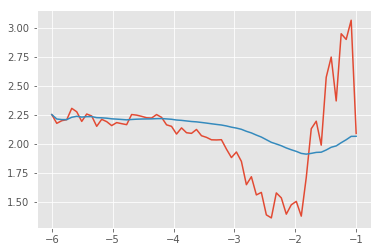

In [50]:
plt.plot(log_lrs, losses)
plt.plot(log_lrs, smooth_losses)
plt.show()

In [51]:
best_lr = 10**(-2.5)

In [52]:
best_lr

0.0031622776601683794

Reference: [Finding a good learning rate](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

# Triangular learning rate

In [82]:
def get_triangular_lr(lr_low, lr_high, iterations, half_cycle_pct=0.45):

    half_cycle = int(half_cycle_pct * iterations)
    left = iterations - 2 * half_cycle
    lrs = np.concatenate([np.linspace(lr_low, lr_high, num=half_cycle, endpoint=False),
                          np.linspace(lr_high, lr_low, num=half_cycle, endpoint=False),
                          np.linspace(lr_low, 0., num=left, endpoint=False)])
    
    mom = np.concatenate([np.linspace(0.95, 0.85, num=half_cycle, endpoint=False),
                          np.linspace(0.85, 0.95, num=half_cycle, endpoint=False),
                          [0.95 for i in range(left)]])
    assert mom.shape == lrs.shape       
    return lrs, mom

In [84]:
lrs, mom = get_triangular_lr(lr_low=1e-4, lr_high=0.08, iterations=3*31)

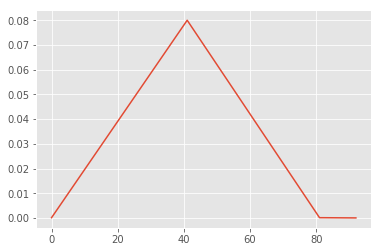

In [90]:
plt.plot(lrs)

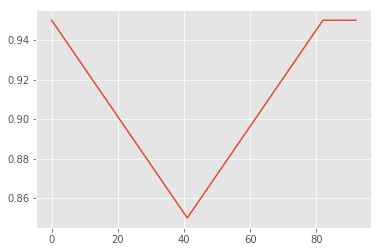

In [91]:
plt.plot(mom)

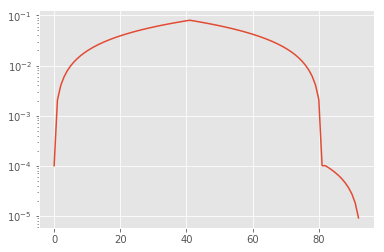

In [73]:
plt.semilogy(lrs)

Interesting Dome shape. lol !!

In [124]:
criteria = nn.CrossEntropyLoss()
loss_criteria = criteria

In [125]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda()
        y = y.cuda()
        out = model(x)
        correct += y.long().eq(out.argmax(dim=1)).sum().item()
        loss = loss_criteria(out, y.long())
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

In [126]:
def train_triangular_policy(model, train_dl, valid_dl,
                            lr_low=1e-5, lr_high=0.01, epochs = 4):
    idx = 0
    iterations = epochs * len(train_dl)
    lrs, mom = get_triangular_lr(lr_low, lr_high, iterations)

    for ep in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            optimizer = get_optimizer(model, lr = lrs[idx], wd=0)
            batch = y.shape[0]
            x = x.cuda()
            y = y.cuda()
            out = model(x)
            loss = loss_criteria(out, y.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch * (loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [127]:
import datetime as dt

def training_loop(model, train_dl, valid_dl, steps=3,
                  lr_low=1e-6, lr_high=0.01, epochs=4):
    for i in range(steps):
        start = dt.datetime.now()
        loss = train_triangular_policy(model, train_dl,
                                       valid_dl, lr_low, lr_high, epochs)
        end = dt.datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [121]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

model = Net().cuda()

In [128]:
val_metrics(model, valid_dl)

val loss and accuracy 2.2020030429425614 0.10261569416498995


In [130]:
training_loop(model, train_dl, valid_dl, steps=1, epochs=3)

train loss 1.5917591712351877
val loss and accuracy 1.397894826933172 0.5311871227364185
train loss 1.1859855465628621
val loss and accuracy 0.9544477489152905 0.7002012072434608
train loss 0.7746012650196665
val loss and accuracy 0.7753814677117576 0.7323943661971831
----End of step Time elapsed 0:23:14.439216


# Unfreezing more layers

In [131]:
save_model(model, 'models/freeze-1')
load_model(model, 'models/freeze-1')

In [132]:
val_metrics(model, valid_dl)

val loss and accuracy 0.7661907556551083 0.7484909456740443


In [ ]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [ ]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])